In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights, EfficientNet_B0_Weights
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             f1_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix)
import numpy as np
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

from codecarbon import track_emissions

In [2]:
# Configurações iniciais
TASK = "Ischaemia"  # "Infection" ou "Ischaemia"
IMG_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 100
MODEL_NAME = "efficientnet"  # "efficientnet" ou "resnet50"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 1. Pré-processamento de Imagens
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
root_dir = "../data/ischaemia"


# 2. Dataset Customizado
class DFUDataset(Dataset):
    def __init__(self, root_dir, task=TASK, transform=None):
        self.root_dir = root_dir
        self.task = task

        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.identifiers = []  # Novo campo para identificadores únicos

        # Validate that root_dir is a valid path
        if not isinstance(root_dir, str):
            raise TypeError(f"Expected root_dir to be a string, but got {type(root_dir).__name__}")

        print("TASK: " + TASK)

        positive_dir = os.path.join(root_dir, "Aug-Positive")
        negative_dir = os.path.join(root_dir, "Aug-Negative")


        # Carregar imagens positivas
        for img_name in os.listdir(positive_dir):
            self.image_paths.append(os.path.join(positive_dir, img_name))
            self.labels.append(1)
            # Extrair identificador único (ex: "imagem" de "imagem_1X_M.jpg")
            identifier = img_name.split('_')[0]
            self.identifiers.append(identifier)

        # Carregar imagens negativas
        for img_name in os.listdir(negative_dir):
            self.image_paths.append(os.path.join(negative_dir, img_name))
            self.labels.append(0)
            identifier = img_name.split('_')[0]
            self.identifiers.append(identifier)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
# 3. Modelo com Regularização
def create_model():
    if MODEL_NAME == "resnet50":
        weights = ResNet50_Weights.IMAGENET1K_V1  # Ou ResNet50_Weights.DEFAULT
        model = models.resnet50(weights=weights)
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 1)
        )
    elif MODEL_NAME == "efficientnet":
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1  # Ou EfficientNet_B0_Weights.DEFAULT
        model = models.efficientnet_b0(weights=weights)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, 1)
        )
    return model.to(DEVICE)

In [6]:
# 6. Cálculo de Métricas
def calculate_metrics(true, preds):
    preds_class = (preds > 0.5).astype(int)
    return {
        'auc': roc_auc_score(true, preds),
        'pr_auc': average_precision_score(true, preds),
        'f1': f1_score(true, preds_class),
        'accuracy': accuracy_score(true, preds_class),
        'precision': precision_score(true, preds_class),
        'recall': recall_score(true, preds_class),
        'confusion_matrix': confusion_matrix(true, preds_class)
    }

In [7]:
# 5. Função de Avaliação
@track_emissions(output_dir="../reports/emissions", output_file="ischaemia_efficientnet.csv") 
def evaluate_model(model, loader, criterion): 
    model.eval()
    losses = []
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            losses.append(loss.item())
            preds = torch.sigmoid(outputs).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    metrics = calculate_metrics(np.array(all_labels), np.array(all_preds))
    return np.mean(losses), metrics

In [8]:
# 4. Função de Treinamento com Early Stopping
def train_model(model, train_loader, val_loader, criterion, optimizer, fold):
    best_loss = float('inf')
    patience_counter = 0
    patience = 3

    history = {
        'train_loss': [],
        'val_loss': [],
        'auc': [],
        'f1': []
    }

    for epoch in range(EPOCHS):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.float().unsqueeze(1).to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Validação
        val_loss, val_metrics = evaluate_model(model, val_loader, criterion)
        epoch_loss = running_loss / len(train_loader.dataset)

        # Registrar métricas
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['auc'].append(val_metrics['auc'])
        history['f1'].append(val_metrics['f1'])

        print(f'Fold {fold}, Epoch {epoch+1}/{EPOCHS}')
        print(f'Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f}')
        print(f'Val AUC: {val_metrics["auc"]:.4f}, F1: {val_metrics["f1"]:.4f}')

        # Early Stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'best_model_fold{fold}.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break

    import os
    output_dir = "../models/ischaemia"
    os.makedirs(output_dir, exist_ok=True)
    # Salva o modelo final do fold
    last_path = os.path.join(output_dir, f"last_model_fold{fold}.pth")
    torch.save(model.state_dict(), last_path)

    return history

In [9]:
# 7. Grad-CAM
def generate_grad_cam(model, img_tensor, target_layer):
    cam = GradCAM(model=model, target_layers=[target_layer], use_cuda=torch.cuda.is_available())
    grayscale_cam = cam(input_tensor=img_tensor.unsqueeze(0))
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(img_tensor.permute(1,2,0).cpu().numpy(), grayscale_cam, use_rgb=True)
    return visualization

In [10]:
def plot_training_histories(histories):
    plt.figure(figsize=(15, 10))

    # Cores para diferentes folds
    colors = ['b', 'g', 'r', 'c', 'm']

    # Plot Loss
    plt.subplot(2, 2, 1)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['train_loss'])+1)
        plt.plot(epochs, history['train_loss'], linestyle='--', color=colors[i], label=f'Fold {i+1} Train')
        plt.plot(epochs, history['val_loss'], linestyle='-', color=colors[i], label=f'Fold {i+1} Val')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot AUC
    plt.subplot(2, 2, 2)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['auc'])+1)
        plt.plot(epochs, history['auc'], color=colors[i], label=f'Fold {i+1}')
    plt.title('Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    # Plot F1-Score
    plt.subplot(2, 2, 3)
    for i, history in enumerate(histories):
        epochs = range(1, len(history['f1'])+1)
        plt.plot(epochs, history['f1'], color=colors[i], label=f'Fold {i+1}')
    plt.title('Validation F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.tight_layout()
    plt.savefig('training_histories.png')
    plt.show()

In [11]:
# 8. Validação Cruzada
@track_emissions(output_dir="../reports/emissions", output_file="ischaemia_efficientnet_cv.csv") 
def cross_validation():

    dataset = DFUDataset("../data/ischaemia", transform=transform)
    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)  # Alterado para StratifiedGroupKFold

    all_metrics = []
    fold_histories = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(
        X=np.zeros(len(dataset.labels)),  # Dummy data
        y=dataset.labels,
        groups=dataset.identifiers  # Grupos dos identificadores
    )):
        print(f'\nFold {fold+1}/5')

        # Split adicional: 80% treino, 20% teste interno
        train_idx, test_idx = train_test_split(
            train_idx,
            test_size=0.2,
            stratify=np.array(dataset.labels)[train_idx],
            random_state=42
        )

        # Split datasets
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_subsampler)
        test_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_subsampler)
        val_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=val_subsampler)

        # Inicialização
        model = create_model()
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)  # L2 regularization

        history = train_model(model, train_loader, val_loader, criterion, optimizer, fold+1)
        fold_histories.append(history)

        plot_training_histories(fold_histories)

        # Avaliação no conjunto de teste interno
        model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
        _, test_metrics = evaluate_model(model, test_loader, criterion)

        # Carregar melhor modelo e avaliar
        model.load_state_dict(torch.load(f'best_model_fold{fold+1}.pth'))
        _, metrics = evaluate_model(model, val_loader, criterion)

         # Adicione as métricas de teste
        all_metrics.append({
            'fold': fold+1,
            'val_metrics': metrics,
            'test_metrics': test_metrics
        })

    pd.DataFrame(fold_histories).to_csv('../reports/metrics/training_history_ischae_efficientnet.csv', index=False)


    # Processar all_metrics para formato tabular
    metrics_rows = []
    for m in all_metrics:
        row = {
            'fold': m['fold'],
            **{f'val_{k}': v for k, v in m['val_metrics'].items()},
            **{f'test_{k}': v for k, v in m['test_metrics'].items()}
        }
        metrics_rows.append(row)

    pd.DataFrame(metrics_rows).to_csv('../reports/metrics/fold_metrics_ischae_efficientnet.csv', index=False)

    # Relatório Final
    print("\nResultados da Validação Cruzada:")

    # Para métricas de validação
    print("\n--- Métricas de Validação ---")
    for key in all_metrics[0]['val_metrics']:
        if key != 'confusion_matrix':
            mean_val = np.mean([m['val_metrics'][key] for m in all_metrics])
            std_val = np.std([m['val_metrics'][key] for m in all_metrics])
            print(f'Val_{key.upper()}: {mean_val:.4f} ± {std_val:.4f}')

    # Para métricas de teste interno
    print("\n--- Métricas de Teste Interno ---")
    for key in all_metrics[0]['test_metrics']:
        if key != 'confusion_matrix':
            mean_test = np.mean([m['test_metrics'][key] for m in all_metrics])
            std_test = np.std([m['test_metrics'][key] for m in all_metrics])
            print(f'Test_{key.upper()}: {mean_test:.4f} ± {std_test:.4f}')

    return fold_histories, all_metrics

[codecarbon WARNING @ 14:52:28] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:52:28] [setup] RAM Tracking...
[codecarbon INFO @ 14:52:28] [setup] CPU Tracking...
[codecarbon WARNING @ 14:52:29] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 14:52:29] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 14:52:29] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 14:52:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 14:52:29] [setup] GPU Tracking...
[codecarbon INFO @ 14:52:29] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 14:52:29] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c

TASK: Ischaemia

Fold 1/5


[codecarbon INFO @ 14:52:48] Energy consumed for RAM : 0.000159 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 14:52:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:52:48] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 14:52:48] Energy consumed for all GPUs : 0.000052 kWh. Total GPU Power : 12.42459844739088 W
[codecarbon INFO @ 14:52:48] 0.000388 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:53:03] Energy consumed for RAM : 0.000317 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 14:53:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:53:03] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 14:53:03] Energy consumed for all GPUs : 0.000102 kWh. Total GPU Power : 12.097221305557694 W
[codecarbon INFO @ 14:53:03] 0.000773 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:5

Fold 1, Epoch 1/100
Train Loss: 0.4048 | Val Loss: 0.5484
Val AUC: 0.8974, F1: 0.8110


[codecarbon INFO @ 14:57:48] Energy consumed for RAM : 0.003324 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 14:57:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:57:48] Energy consumed for All CPU : 0.003718 kWh
[codecarbon INFO @ 14:57:48] Energy consumed for all GPUs : 0.001060 kWh. Total GPU Power : 12.006998320723122 W
[codecarbon INFO @ 14:57:48] 0.008102 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:58:03] Energy consumed for RAM : 0.003482 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 14:58:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:58:03] Energy consumed for All CPU : 0.003895 kWh
[codecarbon INFO @ 14:58:03] Energy consumed for all GPUs : 0.001111 kWh. Total GPU Power : 12.1625555560722 W
[codecarbon INFO @ 14:58:03] 0.008488 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:58

Fold 1, Epoch 2/100
Train Loss: 0.3058 | Val Loss: 0.3897
Val AUC: 0.9439, F1: 0.8586


[codecarbon INFO @ 15:03:03] Energy consumed for RAM : 0.006647 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:03:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:03:03] Energy consumed for All CPU : 0.007437 kWh
[codecarbon INFO @ 15:03:03] Energy consumed for all GPUs : 0.002129 kWh. Total GPU Power : 12.159119495046864 W
[codecarbon INFO @ 15:03:03] 0.016212 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:03:18] Energy consumed for RAM : 0.006805 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:03:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:03:18] Energy consumed for All CPU : 0.007614 kWh
[codecarbon INFO @ 15:03:18] Energy consumed for all GPUs : 0.002179 kWh. Total GPU Power : 12.118423821353021 W
[codecarbon INFO @ 15:03:18] 0.016598 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:

Fold 1, Epoch 3/100
Train Loss: 0.2166 | Val Loss: 0.2742
Val AUC: 0.9671, F1: 0.8919


[codecarbon INFO @ 15:08:03] Energy consumed for RAM : 0.009813 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:08:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:08:03] Energy consumed for All CPU : 0.010979 kWh
[codecarbon INFO @ 15:08:03] Energy consumed for all GPUs : 0.003135 kWh. Total GPU Power : 11.951814004393295 W
[codecarbon INFO @ 15:08:03] 0.023927 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:08:18] Energy consumed for RAM : 0.009971 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:08:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:08:18] Energy consumed for All CPU : 0.011156 kWh
[codecarbon INFO @ 15:08:18] Energy consumed for all GPUs : 0.003186 kWh. Total GPU Power : 12.187692215339329 W
[codecarbon INFO @ 15:08:18] 0.024313 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:

Fold 1, Epoch 4/100
Train Loss: 0.1702 | Val Loss: 0.2306
Val AUC: 0.9729, F1: 0.9127


[codecarbon INFO @ 15:13:18] Energy consumed for RAM : 0.013137 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:13:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:13:18] Energy consumed for All CPU : 0.014697 kWh
[codecarbon INFO @ 15:13:18] Energy consumed for all GPUs : 0.004167 kWh. Total GPU Power : 10.392164681193332 W
[codecarbon INFO @ 15:13:18] 0.032001 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:13:33] Energy consumed for RAM : 0.013295 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:13:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:13:33] Energy consumed for All CPU : 0.014874 kWh
[codecarbon INFO @ 15:13:33] Energy consumed for all GPUs : 0.004210 kWh. Total GPU Power : 10.36329366948417 W
[codecarbon INFO @ 15:13:33] 0.032380 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:1

Fold 1, Epoch 5/100
Train Loss: 0.1383 | Val Loss: 0.2016
Val AUC: 0.9775, F1: 0.9232


[codecarbon INFO @ 15:18:33] Energy consumed for RAM : 0.016461 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:18:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:18:34] Energy consumed for All CPU : 0.018416 kWh
[codecarbon INFO @ 15:18:34] Energy consumed for all GPUs : 0.005263 kWh. Total GPU Power : 11.923119070100082 W
[codecarbon INFO @ 15:18:34] 0.040140 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:18:34] 0.002525 g.CO2eq/s mean an estimation of 79.63380808273057 kg.CO2eq/year
[codecarbon INFO @ 15:18:49] Energy consumed for RAM : 0.016619 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:18:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:18:49] Energy consumed for All CPU : 0.018593 kWh
[codecarbon INFO @ 15:18:49] Energy consumed for all GPUs : 0.005314 kWh. Total GPU Power : 12.229832600369852 W
[codecarbon INFO @ 15:18:49] 0.0

Fold 1, Epoch 6/100
Train Loss: 0.1194 | Val Loss: 0.1988
Val AUC: 0.9771, F1: 0.9179


[codecarbon INFO @ 15:23:49] Energy consumed for RAM : 0.019784 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:23:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:23:49] Energy consumed for All CPU : 0.022135 kWh
[codecarbon INFO @ 15:23:49] Energy consumed for all GPUs : 0.006305 kWh. Total GPU Power : 11.618561963769297 W
[codecarbon INFO @ 15:23:49] 0.048224 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:24:04] Energy consumed for RAM : 0.019942 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:24:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:24:04] Energy consumed for All CPU : 0.022312 kWh
[codecarbon INFO @ 15:24:04] Energy consumed for all GPUs : 0.006355 kWh. Total GPU Power : 12.055613323757262 W
[codecarbon INFO @ 15:24:04] 0.048609 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:

Fold 1, Epoch 7/100
Train Loss: 0.1004 | Val Loss: 0.1912
Val AUC: 0.9787, F1: 0.9225


[codecarbon INFO @ 15:29:04] Energy consumed for RAM : 0.023107 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:29:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:29:04] Energy consumed for All CPU : 0.025853 kWh
[codecarbon INFO @ 15:29:04] Energy consumed for all GPUs : 0.007351 kWh. Total GPU Power : 12.096401677349151 W
[codecarbon INFO @ 15:29:04] 0.056311 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:29:19] Energy consumed for RAM : 0.023266 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:29:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:29:19] Energy consumed for All CPU : 0.026030 kWh
[codecarbon INFO @ 15:29:19] Energy consumed for all GPUs : 0.007402 kWh. Total GPU Power : 12.233515124126368 W
[codecarbon INFO @ 15:29:19] 0.056698 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:

Fold 1, Epoch 8/100
Train Loss: 0.0889 | Val Loss: 0.1967
Val AUC: 0.9775, F1: 0.9193


[codecarbon INFO @ 15:34:19] Energy consumed for RAM : 0.026431 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:34:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:34:19] Energy consumed for All CPU : 0.029571 kWh
[codecarbon INFO @ 15:34:19] Energy consumed for all GPUs : 0.008395 kWh. Total GPU Power : 12.058953282146403 W
[codecarbon INFO @ 15:34:19] 0.064397 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:34:34] Energy consumed for RAM : 0.026589 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:34:34] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:34:34] Energy consumed for All CPU : 0.029748 kWh
[codecarbon INFO @ 15:34:34] Energy consumed for all GPUs : 0.008446 kWh. Total GPU Power : 12.2761503903756 W
[codecarbon INFO @ 15:34:34] 0.064784 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:34

Fold 1, Epoch 9/100
Train Loss: 0.0736 | Val Loss: 0.2048
Val AUC: 0.9785, F1: 0.9164


[codecarbon INFO @ 15:39:49] Energy consumed for RAM : 0.029913 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:39:49] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:39:49] Energy consumed for All CPU : 0.033467 kWh
[codecarbon INFO @ 15:39:49] Energy consumed for all GPUs : 0.009486 kWh. Total GPU Power : 11.858318814491982 W
[codecarbon INFO @ 15:39:49] 0.072866 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:40:04] Energy consumed for RAM : 0.030071 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:40:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:40:04] Energy consumed for All CPU : 0.033644 kWh
[codecarbon INFO @ 15:40:04] Energy consumed for all GPUs : 0.009536 kWh. Total GPU Power : 11.949639487931082 W
[codecarbon INFO @ 15:40:04] 0.073251 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:

Fold 1, Epoch 10/100
Train Loss: 0.0684 | Val Loss: 0.1898
Val AUC: 0.9793, F1: 0.9270


[codecarbon INFO @ 15:45:04] Energy consumed for RAM : 0.033237 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:45:04] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:45:04] Energy consumed for All CPU : 0.037186 kWh
[codecarbon INFO @ 15:45:04] Energy consumed for all GPUs : 0.010535 kWh. Total GPU Power : 11.880801083963945 W
[codecarbon INFO @ 15:45:04] 0.080958 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:45:19] Energy consumed for RAM : 0.033396 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:45:19] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:45:19] Energy consumed for All CPU : 0.037363 kWh
[codecarbon INFO @ 15:45:19] Energy consumed for all GPUs : 0.010584 kWh. Total GPU Power : 11.835659271274208 W
[codecarbon INFO @ 15:45:19] 0.081343 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:

Fold 1, Epoch 11/100
Train Loss: 0.0590 | Val Loss: 0.1990
Val AUC: 0.9788, F1: 0.9214


[codecarbon INFO @ 15:50:20] Energy consumed for RAM : 0.036561 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:50:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:50:20] Energy consumed for All CPU : 0.040905 kWh
[codecarbon INFO @ 15:50:20] Energy consumed for all GPUs : 0.011574 kWh. Total GPU Power : 11.77554520450369 W
[codecarbon INFO @ 15:50:20] 0.089040 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:50:35] Energy consumed for RAM : 0.036720 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:50:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:50:35] Energy consumed for All CPU : 0.041082 kWh
[codecarbon INFO @ 15:50:35] Energy consumed for all GPUs : 0.011624 kWh. Total GPU Power : 11.824697722034298 W
[codecarbon INFO @ 15:50:35] 0.089425 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:5

Fold 1, Epoch 12/100
Train Loss: 0.0477 | Val Loss: 0.2033
Val AUC: 0.9789, F1: 0.9229


[codecarbon INFO @ 15:55:35] Energy consumed for RAM : 0.039885 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:55:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:55:35] Energy consumed for All CPU : 0.044623 kWh
[codecarbon INFO @ 15:55:35] Energy consumed for all GPUs : 0.012615 kWh. Total GPU Power : 11.943642598364114 W
[codecarbon INFO @ 15:55:35] 0.097123 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:55:50] Energy consumed for RAM : 0.040044 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 15:55:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 15:55:50] Energy consumed for All CPU : 0.044800 kWh
[codecarbon INFO @ 15:55:50] Energy consumed for all GPUs : 0.012664 kWh. Total GPU Power : 11.925291068420359 W
[codecarbon INFO @ 15:55:50] 0.097508 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:

Fold 1, Epoch 13/100
Train Loss: 0.0462 | Val Loss: 0.2236
Val AUC: 0.9766, F1: 0.9137
Early stopping at epoch 13


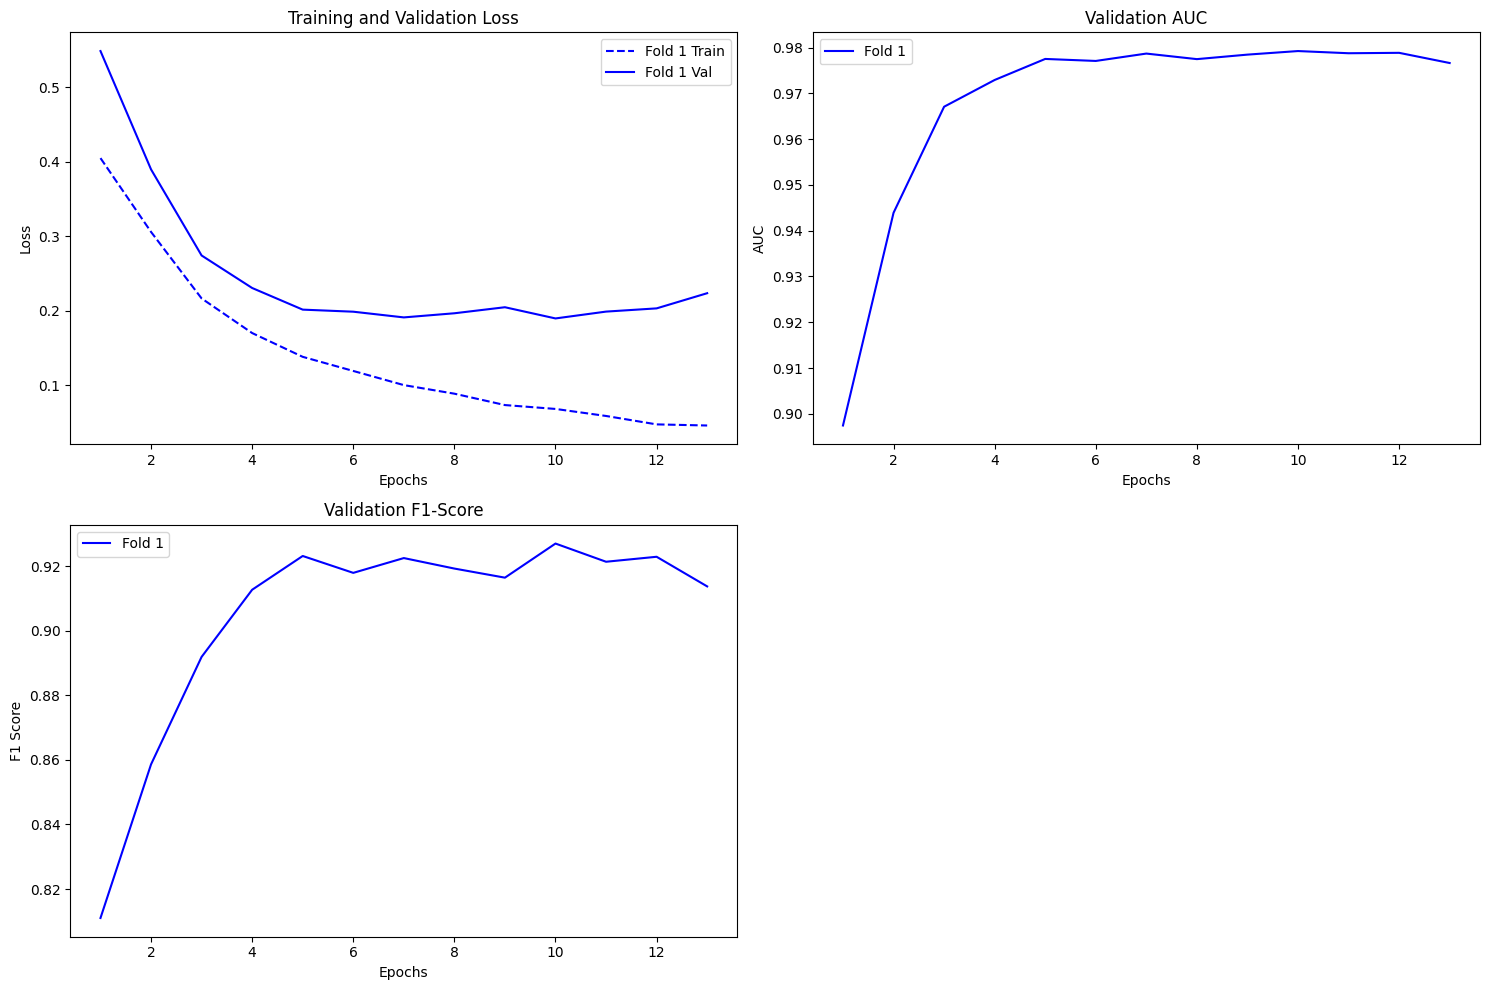

[codecarbon WARNING @ 16:00:45] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:00:45] [setup] RAM Tracking...
[codecarbon INFO @ 16:00:45] [setup] CPU Tracking...
[codecarbon WARNING @ 16:00:45] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 16:00:45] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 16:00:45] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 16:00:45] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:00:45] [setup] GPU Tracking...
[codecarbon INFO @ 16:00:45] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:00:45] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 2/5


[codecarbon INFO @ 16:01:35] Energy consumed for RAM : 0.043684 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:01:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:01:35] Energy consumed for All CPU : 0.048873 kWh
[codecarbon INFO @ 16:01:35] Energy consumed for all GPUs : 0.013805 kWh. Total GPU Power : 11.888405032560225 W
[codecarbon INFO @ 16:01:35] 0.106363 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:01:50] Energy consumed for RAM : 0.043843 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:01:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:01:50] Energy consumed for All CPU : 0.049050 kWh
[codecarbon INFO @ 16:01:50] Energy consumed for all GPUs : 0.013855 kWh. Total GPU Power : 11.943337921890622 W
[codecarbon INFO @ 16:01:50] 0.106748 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:

Fold 2, Epoch 1/100
Train Loss: 0.3889 | Val Loss: 0.5342
Val AUC: 0.8870, F1: 0.8204


[codecarbon INFO @ 16:07:05] Energy consumed for RAM : 0.047167 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:07:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:07:05] Energy consumed for All CPU : 0.052770 kWh
[codecarbon INFO @ 16:07:05] Energy consumed for all GPUs : 0.014914 kWh. Total GPU Power : 12.189186640724005 W
[codecarbon INFO @ 16:07:05] 0.114851 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:07:20] Energy consumed for RAM : 0.047325 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:07:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:07:20] Energy consumed for All CPU : 0.052947 kWh
[codecarbon INFO @ 16:07:20] Energy consumed for all GPUs : 0.014965 kWh. Total GPU Power : 12.021474901557731 W
[codecarbon INFO @ 16:07:20] 0.115236 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:

Fold 2, Epoch 2/100
Train Loss: 0.2778 | Val Loss: 0.4038
Val AUC: 0.9192, F1: 0.8476


[codecarbon INFO @ 16:12:20] Energy consumed for RAM : 0.050491 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:12:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:12:20] Energy consumed for All CPU : 0.056488 kWh
[codecarbon INFO @ 16:12:20] Energy consumed for all GPUs : 0.015966 kWh. Total GPU Power : 12.079379290081214 W
[codecarbon INFO @ 16:12:20] 0.122945 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:12:35] Energy consumed for RAM : 0.050649 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:12:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:12:35] Energy consumed for All CPU : 0.056665 kWh
[codecarbon INFO @ 16:12:35] Energy consumed for all GPUs : 0.016018 kWh. Total GPU Power : 12.306687464545199 W
[codecarbon INFO @ 16:12:35] 0.123332 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:

Fold 2, Epoch 3/100
Train Loss: 0.1924 | Val Loss: 0.3370
Val AUC: 0.9305, F1: 0.8583


[codecarbon INFO @ 16:17:36] Energy consumed for RAM : 0.053815 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:17:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:17:36] Energy consumed for All CPU : 0.060207 kWh
[codecarbon INFO @ 16:17:36] Energy consumed for all GPUs : 0.017017 kWh. Total GPU Power : 11.992076389452064 W
[codecarbon INFO @ 16:17:36] 0.131039 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:17:51] Energy consumed for RAM : 0.053973 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:17:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:17:51] Energy consumed for All CPU : 0.060384 kWh
[codecarbon INFO @ 16:17:51] Energy consumed for all GPUs : 0.017068 kWh. Total GPU Power : 12.109742920799958 W
[codecarbon INFO @ 16:17:51] 0.131425 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:

Fold 2, Epoch 4/100
Train Loss: 0.1447 | Val Loss: 0.3200
Val AUC: 0.9356, F1: 0.8669


[codecarbon INFO @ 16:23:06] Energy consumed for RAM : 0.057297 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:23:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:23:06] Energy consumed for All CPU : 0.064103 kWh
[codecarbon INFO @ 16:23:06] Energy consumed for all GPUs : 0.018117 kWh. Total GPU Power : 11.965314846033285 W
[codecarbon INFO @ 16:23:06] 0.139517 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:23:21] Energy consumed for RAM : 0.057455 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:23:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:23:21] Energy consumed for All CPU : 0.064280 kWh
[codecarbon INFO @ 16:23:21] Energy consumed for all GPUs : 0.018167 kWh. Total GPU Power : 12.073848096214062 W
[codecarbon INFO @ 16:23:21] 0.139902 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:

Fold 2, Epoch 5/100
Train Loss: 0.1163 | Val Loss: 0.3183
Val AUC: 0.9380, F1: 0.8633


[codecarbon INFO @ 16:28:21] Energy consumed for RAM : 0.060621 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:28:21] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:28:21] Energy consumed for All CPU : 0.067821 kWh
[codecarbon INFO @ 16:28:21] Energy consumed for all GPUs : 0.019180 kWh. Total GPU Power : 12.25635468075229 W
[codecarbon INFO @ 16:28:21] 0.147622 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:28:36] Energy consumed for RAM : 0.060779 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:28:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:28:36] Energy consumed for All CPU : 0.067998 kWh
[codecarbon INFO @ 16:28:36] Energy consumed for all GPUs : 0.019230 kWh. Total GPU Power : 12.088471269637395 W
[codecarbon INFO @ 16:28:36] 0.148008 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:2

Fold 2, Epoch 6/100
Train Loss: 0.0968 | Val Loss: 0.3238
Val AUC: 0.9388, F1: 0.8681


[codecarbon INFO @ 16:33:36] Energy consumed for RAM : 0.063944 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:33:36] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:33:36] Energy consumed for All CPU : 0.071540 kWh
[codecarbon INFO @ 16:33:36] Energy consumed for all GPUs : 0.020235 kWh. Total GPU Power : 11.929095433785179 W
[codecarbon INFO @ 16:33:36] 0.155719 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:33:51] Energy consumed for RAM : 0.064102 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:33:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:33:51] Energy consumed for All CPU : 0.071717 kWh
[codecarbon INFO @ 16:33:51] Energy consumed for all GPUs : 0.020285 kWh. Total GPU Power : 11.971304196873664 W
[codecarbon INFO @ 16:33:51] 0.156104 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:

Fold 2, Epoch 7/100
Train Loss: 0.0837 | Val Loss: 0.3318
Val AUC: 0.9381, F1: 0.8677


[codecarbon INFO @ 16:38:51] Energy consumed for RAM : 0.067268 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:38:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:38:51] Energy consumed for All CPU : 0.075258 kWh
[codecarbon INFO @ 16:38:51] Energy consumed for all GPUs : 0.021285 kWh. Total GPU Power : 11.897756449739653 W
[codecarbon INFO @ 16:38:51] 0.163811 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:39:06] Energy consumed for RAM : 0.067426 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:39:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:39:06] Energy consumed for All CPU : 0.075435 kWh
[codecarbon INFO @ 16:39:06] Energy consumed for all GPUs : 0.021336 kWh. Total GPU Power : 12.072915375030771 W
[codecarbon INFO @ 16:39:06] 0.164197 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:

Fold 2, Epoch 8/100
Train Loss: 0.0691 | Val Loss: 0.3523
Val AUC: 0.9364, F1: 0.8679
Early stopping at epoch 8


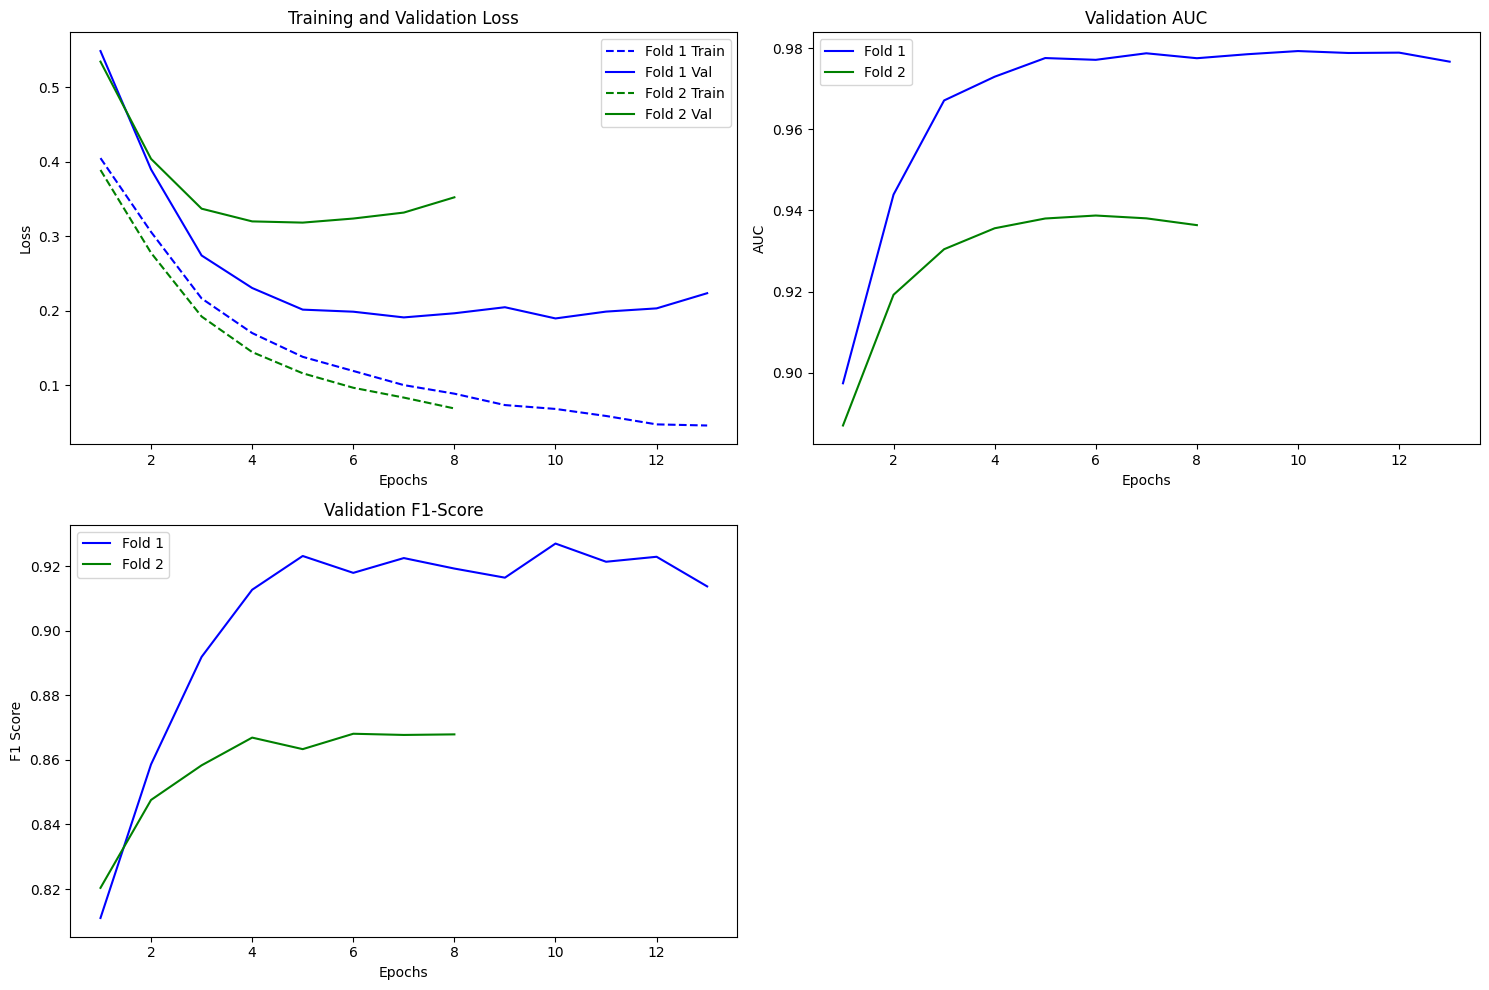

[codecarbon WARNING @ 16:44:09] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:44:09] [setup] RAM Tracking...
[codecarbon INFO @ 16:44:09] [setup] CPU Tracking...
[codecarbon WARNING @ 16:44:09] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 16:44:09] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 16:44:09] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 16:44:09] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:44:09] [setup] GPU Tracking...
[codecarbon INFO @ 16:44:09] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:44:09] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 3/5


[codecarbon INFO @ 16:45:06] Energy consumed for RAM : 0.071225 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:45:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:45:06] Energy consumed for All CPU : 0.079685 kWh
[codecarbon INFO @ 16:45:07] Energy consumed for all GPUs : 0.022537 kWh. Total GPU Power : 12.03852865001428 W
[codecarbon INFO @ 16:45:07] 0.173447 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:45:21] Energy consumed for RAM : 0.071383 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:45:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:45:22] Energy consumed for All CPU : 0.079862 kWh
[codecarbon INFO @ 16:45:22] Energy consumed for all GPUs : 0.022588 kWh. Total GPU Power : 12.237960959938144 W
[codecarbon INFO @ 16:45:22] 0.173834 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:4

Fold 3, Epoch 1/100
Train Loss: 0.4038 | Val Loss: 0.5487
Val AUC: 0.8952, F1: 0.8175


[codecarbon INFO @ 16:50:22] Energy consumed for RAM : 0.074548 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:50:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:50:22] Energy consumed for All CPU : 0.083403 kWh
[codecarbon INFO @ 16:50:22] Energy consumed for all GPUs : 0.023595 kWh. Total GPU Power : 12.10076681799338 W
[codecarbon INFO @ 16:50:22] 0.181546 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:50:37] Energy consumed for RAM : 0.074707 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:50:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:50:37] Energy consumed for All CPU : 0.083580 kWh
[codecarbon INFO @ 16:50:37] Energy consumed for all GPUs : 0.023645 kWh. Total GPU Power : 12.100558997735316 W
[codecarbon INFO @ 16:50:37] 0.181932 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:5

Fold 3, Epoch 2/100
Train Loss: 0.2953 | Val Loss: 0.3832
Val AUC: 0.9466, F1: 0.8803


[codecarbon INFO @ 16:55:37] Energy consumed for RAM : 0.077872 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:55:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:55:37] Energy consumed for All CPU : 0.087122 kWh
[codecarbon INFO @ 16:55:37] Energy consumed for all GPUs : 0.024653 kWh. Total GPU Power : 11.995225944582321 W
[codecarbon INFO @ 16:55:37] 0.189648 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:55:52] Energy consumed for RAM : 0.078031 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 16:55:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:55:52] Energy consumed for All CPU : 0.087299 kWh
[codecarbon INFO @ 16:55:52] Energy consumed for all GPUs : 0.024704 kWh. Total GPU Power : 12.08254137376793 W
[codecarbon INFO @ 16:55:52] 0.190033 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:5

Fold 3, Epoch 3/100
Train Loss: 0.2059 | Val Loss: 0.2879
Val AUC: 0.9605, F1: 0.8996


[codecarbon INFO @ 17:00:52] Energy consumed for RAM : 0.081196 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:00:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:00:52] Energy consumed for All CPU : 0.090841 kWh
[codecarbon INFO @ 17:00:52] Energy consumed for all GPUs : 0.025712 kWh. Total GPU Power : 12.06721811649674 W
[codecarbon INFO @ 17:00:52] 0.197749 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:01:07] Energy consumed for RAM : 0.081355 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:01:07] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:01:07] Energy consumed for All CPU : 0.091018 kWh
[codecarbon INFO @ 17:01:07] Energy consumed for all GPUs : 0.025762 kWh. Total GPU Power : 12.186698087466052 W
[codecarbon INFO @ 17:01:07] 0.198135 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:0

Fold 3, Epoch 4/100
Train Loss: 0.1548 | Val Loss: 0.2587
Val AUC: 0.9656, F1: 0.9028


[codecarbon INFO @ 17:06:22] Energy consumed for RAM : 0.084679 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:06:22] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:06:22] Energy consumed for All CPU : 0.094737 kWh
[codecarbon INFO @ 17:06:22] Energy consumed for all GPUs : 0.026824 kWh. Total GPU Power : 12.123071039848046 W
[codecarbon INFO @ 17:06:22] 0.206240 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:06:37] Energy consumed for RAM : 0.084837 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:06:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:06:37] Energy consumed for All CPU : 0.094914 kWh
[codecarbon INFO @ 17:06:37] Energy consumed for all GPUs : 0.026874 kWh. Total GPU Power : 12.12560622885608 W
[codecarbon INFO @ 17:06:37] 0.206626 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:0

Fold 3, Epoch 5/100
Train Loss: 0.1265 | Val Loss: 0.2309
Val AUC: 0.9687, F1: 0.9155


[codecarbon INFO @ 17:11:37] Energy consumed for RAM : 0.088003 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:11:37] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:11:37] Energy consumed for All CPU : 0.098455 kWh
[codecarbon INFO @ 17:11:37] Energy consumed for all GPUs : 0.027875 kWh. Total GPU Power : 12.011552293636631 W
[codecarbon INFO @ 17:11:37] 0.214334 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:11:52] Energy consumed for RAM : 0.088161 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:11:52] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:11:52] Energy consumed for All CPU : 0.098632 kWh
[codecarbon INFO @ 17:11:52] Energy consumed for all GPUs : 0.027925 kWh. Total GPU Power : 11.982956495801995 W
[codecarbon INFO @ 17:11:52] 0.214719 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:

Fold 3, Epoch 6/100
Train Loss: 0.1099 | Val Loss: 0.2306
Val AUC: 0.9694, F1: 0.9068


[codecarbon INFO @ 17:16:53] Energy consumed for RAM : 0.091327 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:16:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:16:53] Energy consumed for All CPU : 0.102174 kWh
[codecarbon INFO @ 17:16:53] Energy consumed for all GPUs : 0.028927 kWh. Total GPU Power : 12.164468601338598 W
[codecarbon INFO @ 17:16:53] 0.222428 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:17:08] Energy consumed for RAM : 0.091485 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:17:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:17:08] Energy consumed for All CPU : 0.102352 kWh
[codecarbon INFO @ 17:17:08] Energy consumed for all GPUs : 0.028978 kWh. Total GPU Power : 12.190924074367818 W
[codecarbon INFO @ 17:17:08] 0.222815 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:

Fold 3, Epoch 7/100
Train Loss: 0.0938 | Val Loss: 0.2162
Val AUC: 0.9710, F1: 0.9182


[codecarbon INFO @ 17:22:08] Energy consumed for RAM : 0.094651 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:22:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:22:08] Energy consumed for All CPU : 0.105893 kWh
[codecarbon INFO @ 17:22:08] Energy consumed for all GPUs : 0.029977 kWh. Total GPU Power : 12.015304859379675 W
[codecarbon INFO @ 17:22:08] 0.230521 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:22:23] Energy consumed for RAM : 0.094809 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:22:23] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:22:23] Energy consumed for All CPU : 0.106070 kWh
[codecarbon INFO @ 17:22:23] Energy consumed for all GPUs : 0.030028 kWh. Total GPU Power : 12.189939829750266 W
[codecarbon INFO @ 17:22:23] 0.230908 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:

Fold 3, Epoch 8/100
Train Loss: 0.0786 | Val Loss: 0.2441
Val AUC: 0.9696, F1: 0.8993


[codecarbon INFO @ 17:27:38] Energy consumed for RAM : 0.098133 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:27:38] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:38] Energy consumed for All CPU : 0.109789 kWh
[codecarbon INFO @ 17:27:38] Energy consumed for all GPUs : 0.031079 kWh. Total GPU Power : 12.042537818806387 W
[codecarbon INFO @ 17:27:38] 0.239002 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:27:53] Energy consumed for RAM : 0.098292 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:27:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:27:53] Energy consumed for All CPU : 0.109966 kWh
[codecarbon INFO @ 17:27:53] Energy consumed for all GPUs : 0.031130 kWh. Total GPU Power : 12.163196114134825 W
[codecarbon INFO @ 17:27:53] 0.239387 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:

Fold 3, Epoch 9/100
Train Loss: 0.0708 | Val Loss: 0.2518
Val AUC: 0.9684, F1: 0.8964


[codecarbon INFO @ 17:32:53] Energy consumed for RAM : 0.101458 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:32:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:32:53] Energy consumed for All CPU : 0.113508 kWh
[codecarbon INFO @ 17:32:53] Energy consumed for all GPUs : 0.032132 kWh. Total GPU Power : 11.91936671201666 W
[codecarbon INFO @ 17:32:53] 0.247097 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:33:08] Energy consumed for RAM : 0.101616 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:33:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:33:08] Energy consumed for All CPU : 0.113685 kWh
[codecarbon INFO @ 17:33:08] Energy consumed for all GPUs : 0.032182 kWh. Total GPU Power : 12.126019197859268 W
[codecarbon INFO @ 17:33:08] 0.247483 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:3

Fold 3, Epoch 10/100
Train Loss: 0.0583 | Val Loss: 0.2418
Val AUC: 0.9699, F1: 0.9029
Early stopping at epoch 10


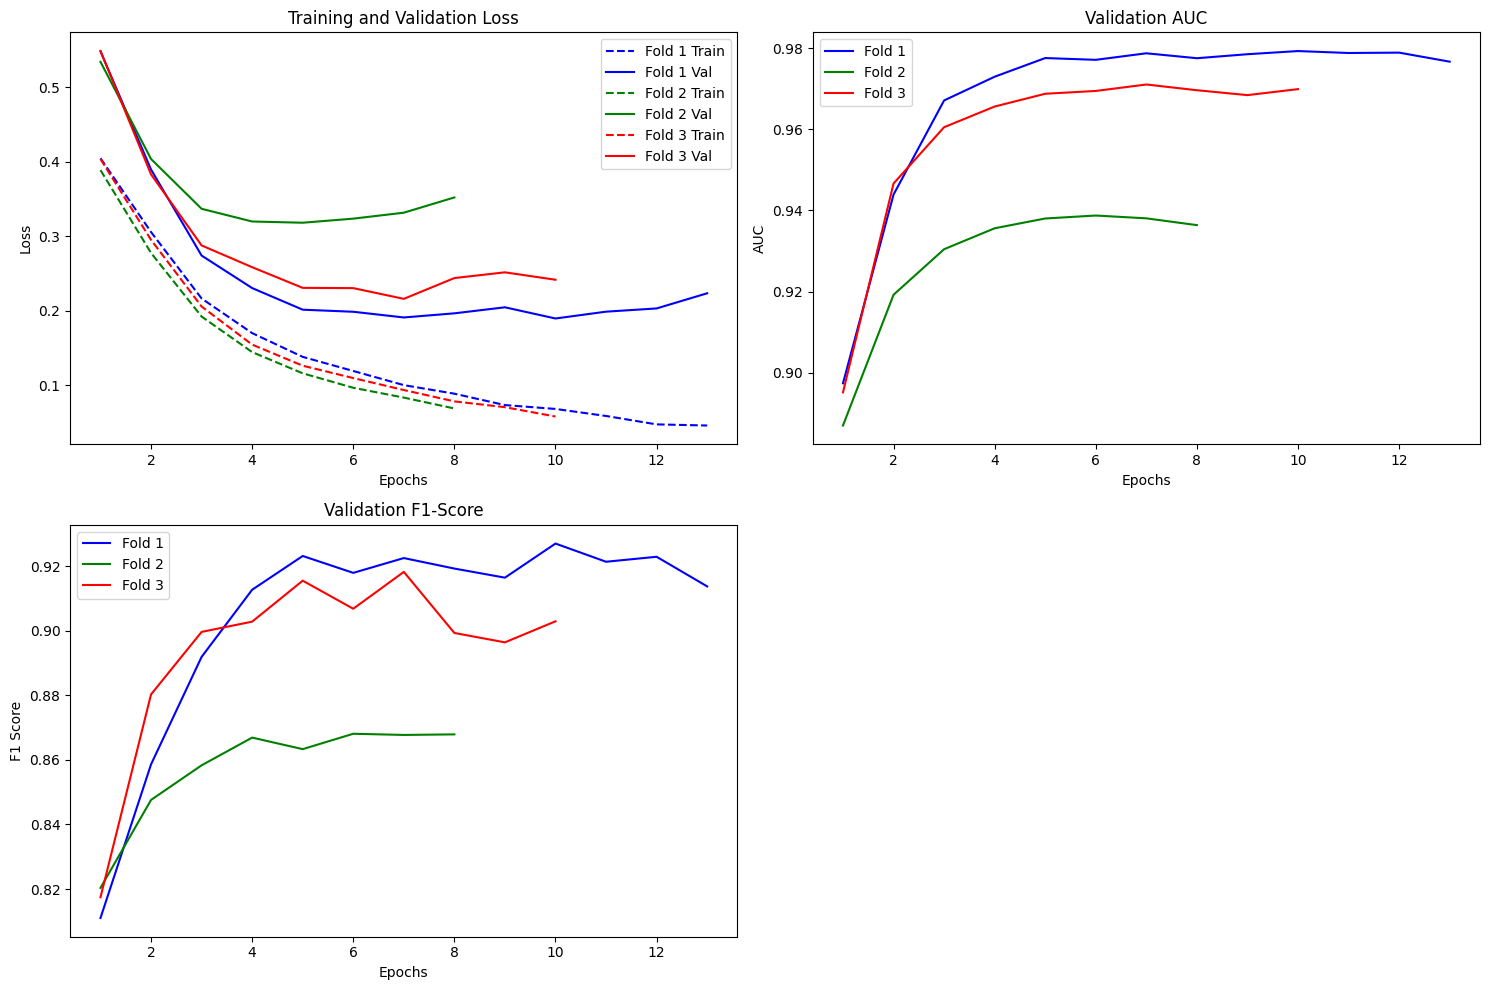

[codecarbon WARNING @ 17:38:01] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 17:38:01] [setup] RAM Tracking...
[codecarbon INFO @ 17:38:01] [setup] CPU Tracking...
[codecarbon WARNING @ 17:38:01] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 17:38:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 17:38:02] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 17:38:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 17:38:02] [setup] GPU Tracking...
[codecarbon INFO @ 17:38:02] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 17:38:02] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 4/5


[codecarbon INFO @ 17:38:53] Energy consumed for RAM : 0.105256 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:38:53] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:38:53] Energy consumed for All CPU : 0.117757 kWh
[codecarbon INFO @ 17:38:53] Energy consumed for all GPUs : 0.033335 kWh. Total GPU Power : 11.824821310362095 W
[codecarbon INFO @ 17:38:53] 0.256348 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:39:08] Energy consumed for RAM : 0.105414 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:39:08] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:39:08] Energy consumed for All CPU : 0.117934 kWh
[codecarbon INFO @ 17:39:08] Energy consumed for all GPUs : 0.033384 kWh. Total GPU Power : 11.909019170591828 W
[codecarbon INFO @ 17:39:08] 0.256733 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:

Fold 4, Epoch 1/100
Train Loss: 0.4035 | Val Loss: 0.5614
Val AUC: 0.8443, F1: 0.7357


[codecarbon INFO @ 17:44:09] Energy consumed for RAM : 0.108580 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:44:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:44:09] Energy consumed for All CPU : 0.121476 kWh
[codecarbon INFO @ 17:44:09] Energy consumed for all GPUs : 0.034385 kWh. Total GPU Power : 11.94089308373638 W
[codecarbon INFO @ 17:44:09] 0.264440 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:44:24] Energy consumed for RAM : 0.108738 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:44:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:44:24] Energy consumed for All CPU : 0.121653 kWh
[codecarbon INFO @ 17:44:24] Energy consumed for all GPUs : 0.034435 kWh. Total GPU Power : 11.868421188338521 W
[codecarbon INFO @ 17:44:24] 0.264825 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:4

Fold 4, Epoch 2/100
Train Loss: 0.2869 | Val Loss: 0.4097
Val AUC: 0.9239, F1: 0.8092


[codecarbon INFO @ 17:49:39] Energy consumed for RAM : 0.112062 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:49:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:49:39] Energy consumed for All CPU : 0.125371 kWh
[codecarbon INFO @ 17:49:39] Energy consumed for all GPUs : 0.035500 kWh. Total GPU Power : 12.156888896140739 W
[codecarbon INFO @ 17:49:39] 0.272932 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:49:54] Energy consumed for RAM : 0.112220 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:49:54] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:49:54] Energy consumed for All CPU : 0.125548 kWh
[codecarbon INFO @ 17:49:54] Energy consumed for all GPUs : 0.035550 kWh. Total GPU Power : 12.119658892837208 W
[codecarbon INFO @ 17:49:54] 0.273318 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:

Fold 4, Epoch 3/100
Train Loss: 0.1993 | Val Loss: 0.3096
Val AUC: 0.9552, F1: 0.8583


[codecarbon INFO @ 17:54:54] Energy consumed for RAM : 0.115386 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:54:54] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:54:54] Energy consumed for All CPU : 0.129090 kWh
[codecarbon INFO @ 17:54:54] Energy consumed for all GPUs : 0.036541 kWh. Total GPU Power : 11.910920756794388 W
[codecarbon INFO @ 17:54:54] 0.281017 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:55:09] Energy consumed for RAM : 0.115544 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 17:55:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 17:55:09] Energy consumed for All CPU : 0.129267 kWh
[codecarbon INFO @ 17:55:09] Energy consumed for all GPUs : 0.036591 kWh. Total GPU Power : 12.114999322391785 W
[codecarbon INFO @ 17:55:09] 0.281402 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 17:

Fold 4, Epoch 4/100
Train Loss: 0.1546 | Val Loss: 0.2601
Val AUC: 0.9649, F1: 0.8912


[codecarbon INFO @ 18:00:09] Energy consumed for RAM : 0.118709 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:00:09] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:00:09] Energy consumed for All CPU : 0.132809 kWh
[codecarbon INFO @ 18:00:09] Energy consumed for all GPUs : 0.037591 kWh. Total GPU Power : 12.097021329718375 W
[codecarbon INFO @ 18:00:09] 0.289109 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:00:24] Energy consumed for RAM : 0.118867 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:00:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:00:24] Energy consumed for All CPU : 0.132986 kWh
[codecarbon INFO @ 18:00:24] Energy consumed for all GPUs : 0.037642 kWh. Total GPU Power : 12.034599926448857 W
[codecarbon INFO @ 18:00:24] 0.289494 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:

Fold 4, Epoch 5/100
Train Loss: 0.1266 | Val Loss: 0.2382
Val AUC: 0.9709, F1: 0.8939


[codecarbon INFO @ 18:05:24] Energy consumed for RAM : 0.122032 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:05:24] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:05:24] Energy consumed for All CPU : 0.136527 kWh
[codecarbon INFO @ 18:05:24] Energy consumed for all GPUs : 0.038643 kWh. Total GPU Power : 11.987359049157536 W
[codecarbon INFO @ 18:05:24] 0.297202 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:05:39] Energy consumed for RAM : 0.122190 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:05:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:05:39] Energy consumed for All CPU : 0.136704 kWh
[codecarbon INFO @ 18:05:39] Energy consumed for all GPUs : 0.038693 kWh. Total GPU Power : 11.903268254900459 W
[codecarbon INFO @ 18:05:39] 0.297587 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:

Fold 4, Epoch 6/100
Train Loss: 0.1063 | Val Loss: 0.2366
Val AUC: 0.9710, F1: 0.8928


[codecarbon INFO @ 18:10:39] Energy consumed for RAM : 0.125356 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:10:39] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:10:39] Energy consumed for All CPU : 0.140246 kWh
[codecarbon INFO @ 18:10:39] Energy consumed for all GPUs : 0.039699 kWh. Total GPU Power : 11.974230069351105 W
[codecarbon INFO @ 18:10:39] 0.305301 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:10:39] 0.002530 g.CO2eq/s mean an estimation of 79.77711817795199 kg.CO2eq/year
[codecarbon INFO @ 18:10:54] Energy consumed for RAM : 0.125514 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:10:54] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:10:54] Energy consumed for All CPU : 0.140423 kWh
[codecarbon INFO @ 18:10:54] Energy consumed for all GPUs : 0.039750 kWh. Total GPU Power : 12.13413080236198 W
[codecarbon INFO @ 18:10:54] 0.30

Fold 4, Epoch 7/100
Train Loss: 0.0910 | Val Loss: 0.2312
Val AUC: 0.9715, F1: 0.8963


[codecarbon INFO @ 18:15:55] Energy consumed for RAM : 0.128680 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:15:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:15:55] Energy consumed for All CPU : 0.143965 kWh
[codecarbon INFO @ 18:15:55] Energy consumed for all GPUs : 0.040742 kWh. Total GPU Power : 10.92782808735229 W
[codecarbon INFO @ 18:15:55] 0.313387 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:16:10] Energy consumed for RAM : 0.128839 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:16:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:16:10] Energy consumed for All CPU : 0.144142 kWh
[codecarbon INFO @ 18:16:10] Energy consumed for all GPUs : 0.040788 kWh. Total GPU Power : 11.209667286734335 W
[codecarbon INFO @ 18:16:10] 0.313769 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:1

Fold 4, Epoch 8/100
Train Loss: 0.0772 | Val Loss: 0.2209
Val AUC: 0.9734, F1: 0.9015


[codecarbon INFO @ 18:21:10] Energy consumed for RAM : 0.132004 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:21:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:21:10] Energy consumed for All CPU : 0.147683 kWh
[codecarbon INFO @ 18:21:10] Energy consumed for all GPUs : 0.041814 kWh. Total GPU Power : 12.023139071016383 W
[codecarbon INFO @ 18:21:10] 0.321501 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:21:25] Energy consumed for RAM : 0.132162 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:21:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:21:25] Energy consumed for All CPU : 0.147860 kWh
[codecarbon INFO @ 18:21:25] Energy consumed for all GPUs : 0.041864 kWh. Total GPU Power : 11.904222982629106 W
[codecarbon INFO @ 18:21:25] 0.321886 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:

Fold 4, Epoch 9/100
Train Loss: 0.0707 | Val Loss: 0.2289
Val AUC: 0.9733, F1: 0.9016


[codecarbon INFO @ 18:26:25] Energy consumed for RAM : 0.135328 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:26:25] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:26:25] Energy consumed for All CPU : 0.151403 kWh
[codecarbon INFO @ 18:26:25] Energy consumed for all GPUs : 0.042872 kWh. Total GPU Power : 11.854185718902638 W
[codecarbon INFO @ 18:26:25] 0.329602 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:26:40] Energy consumed for RAM : 0.135486 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:26:40] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:26:40] Energy consumed for All CPU : 0.151579 kWh
[codecarbon INFO @ 18:26:40] Energy consumed for all GPUs : 0.042922 kWh. Total GPU Power : 12.170937322250525 W
[codecarbon INFO @ 18:26:40] 0.329988 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:

Fold 4, Epoch 10/100
Train Loss: 0.0571 | Val Loss: 0.2501
Val AUC: 0.9721, F1: 0.8859


[codecarbon INFO @ 18:31:55] Energy consumed for RAM : 0.138811 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:31:55] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:31:55] Energy consumed for All CPU : 0.155299 kWh
[codecarbon INFO @ 18:31:55] Energy consumed for all GPUs : 0.043980 kWh. Total GPU Power : 12.098250557281963 W
[codecarbon INFO @ 18:31:55] 0.338089 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:32:10] Energy consumed for RAM : 0.138969 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:32:10] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:32:10] Energy consumed for All CPU : 0.155475 kWh
[codecarbon INFO @ 18:32:10] Energy consumed for all GPUs : 0.044030 kWh. Total GPU Power : 12.12565280960394 W
[codecarbon INFO @ 18:32:10] 0.338474 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:3

Fold 4, Epoch 11/100
Train Loss: 0.0583 | Val Loss: 0.2460
Val AUC: 0.9725, F1: 0.8963
Early stopping at epoch 11


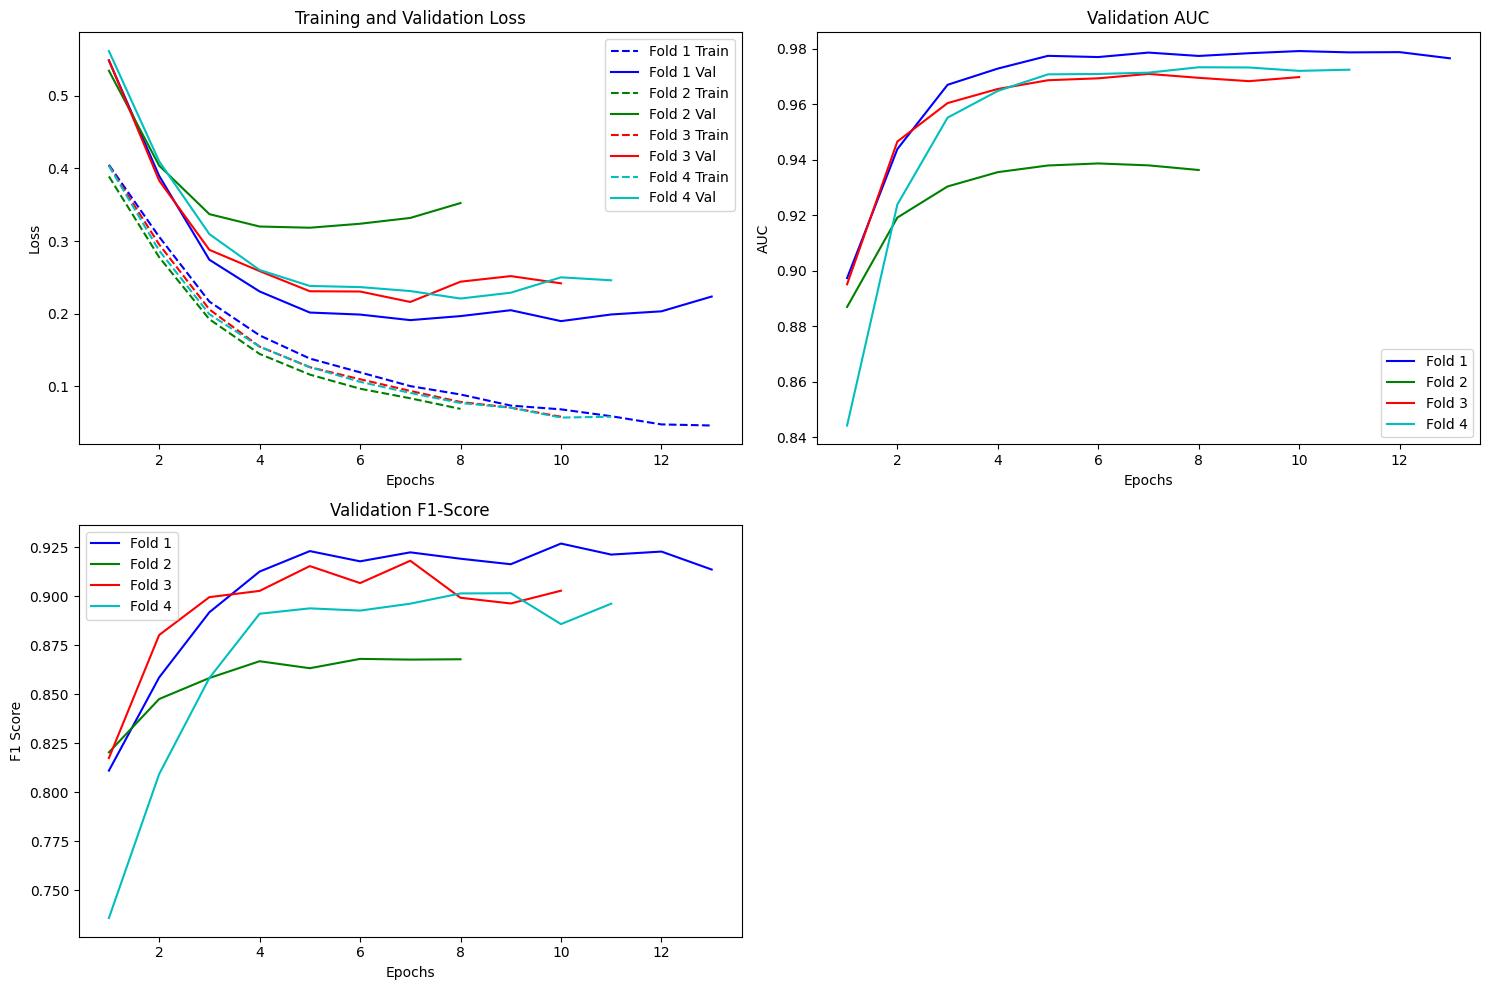

[codecarbon WARNING @ 18:37:01] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 18:37:02] [setup] RAM Tracking...
[codecarbon INFO @ 18:37:02] [setup] CPU Tracking...
[codecarbon WARNING @ 18:37:02] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 18:37:02] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 18:37:02] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 18:37:02] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:37:02] [setup] GPU Tracking...
[codecarbon INFO @ 18:37:02] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:37:02] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Fold 5/5


[codecarbon INFO @ 18:37:56] Energy consumed for RAM : 0.142609 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:37:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:37:56] Energy consumed for All CPU : 0.159548 kWh
[codecarbon INFO @ 18:37:56] Energy consumed for all GPUs : 0.045181 kWh. Total GPU Power : 11.994931731775756 W
[codecarbon INFO @ 18:37:56] 0.347338 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:38:11] Energy consumed for RAM : 0.142768 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:38:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:38:11] Energy consumed for All CPU : 0.159725 kWh
[codecarbon INFO @ 18:38:11] Energy consumed for all GPUs : 0.045231 kWh. Total GPU Power : 12.069578066367205 W
[codecarbon INFO @ 18:38:11] 0.347724 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:

Fold 5, Epoch 1/100
Train Loss: 0.3986 | Val Loss: 0.5247
Val AUC: 0.9257, F1: 0.8422


[codecarbon INFO @ 18:43:11] Energy consumed for RAM : 0.145933 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:43:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:43:11] Energy consumed for All CPU : 0.163267 kWh
[codecarbon INFO @ 18:43:11] Energy consumed for all GPUs : 0.046232 kWh. Total GPU Power : 11.87652913972169 W
[codecarbon INFO @ 18:43:11] 0.355432 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:43:26] Energy consumed for RAM : 0.146091 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:43:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:43:26] Energy consumed for All CPU : 0.163444 kWh
[codecarbon INFO @ 18:43:26] Energy consumed for all GPUs : 0.046281 kWh. Total GPU Power : 11.931383772329172 W
[codecarbon INFO @ 18:43:26] 0.355817 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:4

Fold 5, Epoch 2/100
Train Loss: 0.3021 | Val Loss: 0.3639
Val AUC: 0.9656, F1: 0.9035


[codecarbon INFO @ 18:48:41] Energy consumed for RAM : 0.149415 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:48:41] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:48:41] Energy consumed for All CPU : 0.167163 kWh
[codecarbon INFO @ 18:48:41] Energy consumed for all GPUs : 0.047342 kWh. Total GPU Power : 12.208097715021855 W
[codecarbon INFO @ 18:48:41] 0.363920 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:48:41] 0.002528 g.CO2eq/s mean an estimation of 79.72182184947562 kg.CO2eq/year
[codecarbon INFO @ 18:48:56] Energy consumed for RAM : 0.149574 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:48:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:48:56] Energy consumed for All CPU : 0.167340 kWh
[codecarbon INFO @ 18:48:56] Energy consumed for all GPUs : 0.047392 kWh. Total GPU Power : 12.181149938014768 W
[codecarbon INFO @ 18:48:56] 0.3

Fold 5, Epoch 3/100
Train Loss: 0.2196 | Val Loss: 0.2545
Val AUC: 0.9784, F1: 0.9320


[codecarbon INFO @ 18:53:56] Energy consumed for RAM : 0.152739 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:53:56] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:53:56] Energy consumed for All CPU : 0.170882 kWh
[codecarbon INFO @ 18:53:56] Energy consumed for all GPUs : 0.048394 kWh. Total GPU Power : 11.91830297918223 W
[codecarbon INFO @ 18:53:56] 0.372016 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:54:11] Energy consumed for RAM : 0.152898 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:54:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:54:11] Energy consumed for All CPU : 0.171059 kWh
[codecarbon INFO @ 18:54:11] Energy consumed for all GPUs : 0.048444 kWh. Total GPU Power : 12.072197721217197 W
[codecarbon INFO @ 18:54:11] 0.372401 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:5

Fold 5, Epoch 4/100
Train Loss: 0.1688 | Val Loss: 0.1982
Val AUC: 0.9824, F1: 0.9400


[codecarbon INFO @ 18:59:11] Energy consumed for RAM : 0.156063 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:59:11] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:59:11] Energy consumed for All CPU : 0.174600 kWh
[codecarbon INFO @ 18:59:11] Energy consumed for all GPUs : 0.049442 kWh. Total GPU Power : 11.929023783921256 W
[codecarbon INFO @ 18:59:11] 0.380106 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:59:26] Energy consumed for RAM : 0.156222 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 18:59:26] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 18:59:26] Energy consumed for All CPU : 0.174778 kWh
[codecarbon INFO @ 18:59:26] Energy consumed for all GPUs : 0.049492 kWh. Total GPU Power : 12.043942797261245 W
[codecarbon INFO @ 18:59:26] 0.380492 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 18:

Fold 5, Epoch 5/100
Train Loss: 0.1382 | Val Loss: 0.1753
Val AUC: 0.9849, F1: 0.9425


[codecarbon INFO @ 19:04:42] Energy consumed for RAM : 0.159546 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:04:42] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:04:42] Energy consumed for All CPU : 0.178497 kWh
[codecarbon INFO @ 19:04:42] Energy consumed for all GPUs : 0.050552 kWh. Total GPU Power : 12.096693388294723 W
[codecarbon INFO @ 19:04:42] 0.388594 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:04:42] 0.002528 g.CO2eq/s mean an estimation of 79.72224301478415 kg.CO2eq/year
[codecarbon INFO @ 19:04:57] Energy consumed for RAM : 0.159704 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:04:57] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:04:57] Energy consumed for All CPU : 0.178674 kWh
[codecarbon INFO @ 19:04:57] Energy consumed for all GPUs : 0.050602 kWh. Total GPU Power : 12.083758353530616 W
[codecarbon INFO @ 19:04:57] 0.3

Fold 5, Epoch 6/100
Train Loss: 0.1183 | Val Loss: 0.1627
Val AUC: 0.9840, F1: 0.9471


[codecarbon INFO @ 19:09:57] Energy consumed for RAM : 0.162870 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:09:57] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:09:57] Energy consumed for All CPU : 0.182215 kWh
[codecarbon INFO @ 19:09:57] Energy consumed for all GPUs : 0.051605 kWh. Total GPU Power : 11.882725286210368 W
[codecarbon INFO @ 19:09:57] 0.396690 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:10:12] Energy consumed for RAM : 0.163028 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:10:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:10:12] Energy consumed for All CPU : 0.182392 kWh
[codecarbon INFO @ 19:10:12] Energy consumed for all GPUs : 0.051656 kWh. Total GPU Power : 12.173666687896462 W
[codecarbon INFO @ 19:10:12] 0.397076 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:

Fold 5, Epoch 7/100
Train Loss: 0.1000 | Val Loss: 0.1548
Val AUC: 0.9848, F1: 0.9484


[codecarbon INFO @ 19:15:12] Energy consumed for RAM : 0.166193 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:15:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:15:12] Energy consumed for All CPU : 0.185934 kWh
[codecarbon INFO @ 19:15:12] Energy consumed for all GPUs : 0.052665 kWh. Total GPU Power : 11.924727295666369 W
[codecarbon INFO @ 19:15:12] 0.404792 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:15:27] Energy consumed for RAM : 0.166352 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:15:27] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:15:27] Energy consumed for All CPU : 0.186111 kWh
[codecarbon INFO @ 19:15:27] Energy consumed for all GPUs : 0.052715 kWh. Total GPU Power : 11.955076490861602 W
[codecarbon INFO @ 19:15:27] 0.405177 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:

Fold 5, Epoch 8/100
Train Loss: 0.0866 | Val Loss: 0.1523
Val AUC: 0.9853, F1: 0.9472


[codecarbon INFO @ 19:20:27] Energy consumed for RAM : 0.169517 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:20:27] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:20:27] Energy consumed for All CPU : 0.189653 kWh
[codecarbon INFO @ 19:20:27] Energy consumed for all GPUs : 0.053721 kWh. Total GPU Power : 12.119776514122286 W
[codecarbon INFO @ 19:20:27] 0.412890 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:20:42] Energy consumed for RAM : 0.169675 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:20:42] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:20:42] Energy consumed for All CPU : 0.189830 kWh
[codecarbon INFO @ 19:20:42] Energy consumed for all GPUs : 0.053771 kWh. Total GPU Power : 11.974878112389082 W
[codecarbon INFO @ 19:20:42] 0.413276 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:

Fold 5, Epoch 9/100
Train Loss: 0.0747 | Val Loss: 0.1544
Val AUC: 0.9840, F1: 0.9425


[codecarbon INFO @ 19:25:57] Energy consumed for RAM : 0.172999 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:25:57] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:25:57] Energy consumed for All CPU : 0.193548 kWh
[codecarbon INFO @ 19:25:57] Energy consumed for all GPUs : 0.054820 kWh. Total GPU Power : 11.933140726821671 W
[codecarbon INFO @ 19:25:57] 0.421367 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:26:12] Energy consumed for RAM : 0.173157 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:26:12] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:26:12] Energy consumed for All CPU : 0.193725 kWh
[codecarbon INFO @ 19:26:12] Energy consumed for all GPUs : 0.054869 kWh. Total GPU Power : 11.81754787591794 W
[codecarbon INFO @ 19:26:12] 0.421752 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:2

Fold 5, Epoch 10/100
Train Loss: 0.0663 | Val Loss: 0.1508
Val AUC: 0.9850, F1: 0.9479


[codecarbon INFO @ 19:31:13] Energy consumed for RAM : 0.176323 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:31:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:31:13] Energy consumed for All CPU : 0.197267 kWh
[codecarbon INFO @ 19:31:13] Energy consumed for all GPUs : 0.055849 kWh. Total GPU Power : 11.76977062650346 W
[codecarbon INFO @ 19:31:13] 0.429439 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:31:28] Energy consumed for RAM : 0.176481 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:31:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:31:28] Energy consumed for All CPU : 0.197444 kWh
[codecarbon INFO @ 19:31:28] Energy consumed for all GPUs : 0.055899 kWh. Total GPU Power : 11.820953743724147 W
[codecarbon INFO @ 19:31:28] 0.429824 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:3

Fold 5, Epoch 11/100
Train Loss: 0.0581 | Val Loss: 0.1489
Val AUC: 0.9851, F1: 0.9452


[codecarbon INFO @ 19:36:28] Energy consumed for RAM : 0.179647 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:36:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:36:28] Energy consumed for All CPU : 0.200986 kWh
[codecarbon INFO @ 19:36:28] Energy consumed for all GPUs : 0.056890 kWh. Total GPU Power : 11.786806151593979 W
[codecarbon INFO @ 19:36:28] 0.437523 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:36:43] Energy consumed for RAM : 0.179805 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:36:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:36:43] Energy consumed for All CPU : 0.201163 kWh
[codecarbon INFO @ 19:36:43] Energy consumed for all GPUs : 0.056940 kWh. Total GPU Power : 11.950943591440243 W
[codecarbon INFO @ 19:36:43] 0.437908 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:

Fold 5, Epoch 12/100
Train Loss: 0.0490 | Val Loss: 0.1643
Val AUC: 0.9840, F1: 0.9371


[codecarbon INFO @ 19:41:58] Energy consumed for RAM : 0.183129 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:41:58] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:41:58] Energy consumed for All CPU : 0.204881 kWh
[codecarbon INFO @ 19:41:58] Energy consumed for all GPUs : 0.057989 kWh. Total GPU Power : 11.962547506159819 W
[codecarbon INFO @ 19:41:58] 0.445999 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:42:13] Energy consumed for RAM : 0.183287 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:42:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:42:13] Energy consumed for All CPU : 0.205058 kWh
[codecarbon INFO @ 19:42:13] Energy consumed for all GPUs : 0.058039 kWh. Total GPU Power : 11.952794601598898 W
[codecarbon INFO @ 19:42:13] 0.446384 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:

Fold 5, Epoch 13/100
Train Loss: 0.0458 | Val Loss: 0.1553
Val AUC: 0.9843, F1: 0.9474


[codecarbon INFO @ 19:47:13] Energy consumed for RAM : 0.186453 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:47:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:47:13] Energy consumed for All CPU : 0.208600 kWh
[codecarbon INFO @ 19:47:13] Energy consumed for all GPUs : 0.059037 kWh. Total GPU Power : 11.759418836245882 W
[codecarbon INFO @ 19:47:13] 0.454089 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:47:28] Energy consumed for RAM : 0.186611 kWh. RAM Power : 38.0 W
[codecarbon INFO @ 19:47:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 19:47:28] Energy consumed for All CPU : 0.208777 kWh
[codecarbon INFO @ 19:47:28] Energy consumed for all GPUs : 0.059086 kWh. Total GPU Power : 11.8384892387028 W
[codecarbon INFO @ 19:47:28] 0.454474 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 19:47

Fold 5, Epoch 14/100
Train Loss: 0.0385 | Val Loss: 0.1646
Val AUC: 0.9831, F1: 0.9413
Early stopping at epoch 14


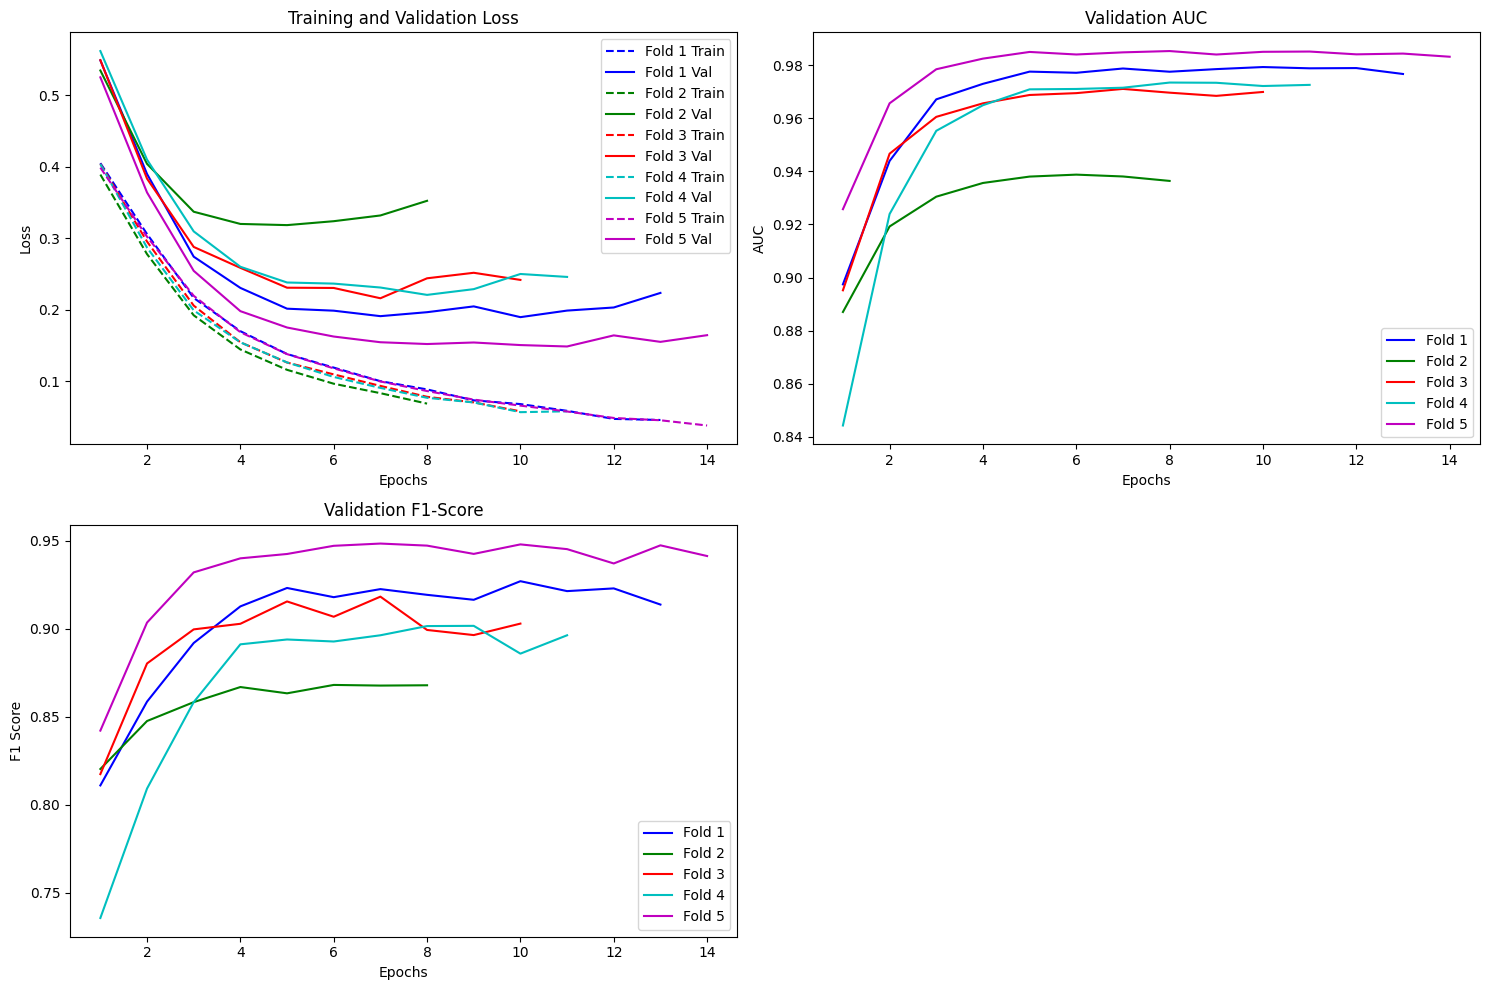

[codecarbon WARNING @ 19:52:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 19:52:27] [setup] RAM Tracking...
[codecarbon INFO @ 19:52:27] [setup] CPU Tracking...
[codecarbon WARNING @ 19:52:27] We saw that you have a Intel(R) Core(TM) i9-14900 but we don't know it. Please contact us.
[codecarbon WARNING @ 19:52:27] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon INFO @ 19:52:27] CPU Model on constant consumption mode: Intel(R) Core(TM) i9-14900
[codecarbon WARNING @ 19:52:27] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 19:52:27] [setup] GPU Tracking...
[codecarbon INFO @ 19:52:27] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 19:52:27] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global c


Resultados da Validação Cruzada:

--- Métricas de Validação ---
Val_AUC: 0.9694 ± 0.0164
Val_PR_AUC: 0.9725 ± 0.0135
Val_F1: 0.9111 ± 0.0277
Val_ACCURACY: 0.9129 ± 0.0271
Val_PRECISION: 0.9297 ± 0.0283
Val_RECALL: 0.8934 ± 0.0318

--- Métricas de Teste Interno ---
Test_AUC: 0.9953 ± 0.0021
Test_PR_AUC: 0.9953 ± 0.0020
Test_F1: 0.9676 ± 0.0068
Test_ACCURACY: 0.9672 ± 0.0068
Test_PRECISION: 0.9561 ± 0.0072
Test_RECALL: 0.9795 ± 0.0106
CPU times: total: 4d 20h 48min 30s
Wall time: 5h 46s


In [12]:
%%time
# Executar
if __name__ == "__main__":
    fold_histories, all_metrics = cross_validation()

    # Exemplo Grad-CAM
    # model = create_model().eval()
    # sample_img, _ = dataset[0]
    # target_layer = model.layer4[-1] if MODEL_NAME == "resnet50" else model.features[-1]
    # cam_image = generate_grad_cam(model, sample_img.to(DEVICE), target_layer)
    #
    # plt.imshow(cam_image)
    # plt.title('Grad-CAM Visualization')
    # plt.axis('off')
    # plt.show()